In [1]:
!pip install rasterio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import das bibliotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import rasterio as rio

import io
import os
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

Parametros de visualização (cores do mapa)

In [4]:
values_list = [0, 1, 2, 3, 4, 5, 6]
colors_list = ['white', '#006400', '#BBFCAC', '#FFFFB2', '#EA9999', '#aa0000', '#0000FF']
cmap = ListedColormap(colors_list, name='custom_cmap', N=len(colors_list))

Acesso ao GDrive

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Importando e decodificando imagens GeoTIFF

In [6]:
sorting_criterion = lambda e: e["name"]

def importando_imagens(path_diretorio):
    imagens = [];
    for filename in os.listdir(path_diretorio):
        if filename.endswith(".tiff") or filename.endswith(".tif"):
            with rio.open(os.path.join(path_diretorio, filename)) as src:
                imagens.append({"image":src.read(), "name": filename});

    imagens.sort(key = sorting_criterion);
    apenas_imagens = [i["image"] for i in imagens]
    return np.array(apenas_imagens)

In [7]:
def show_series(list_of_images):
    for elemento in list_of_images:
        show(elemento, cmap = cmap)

In [8]:
def plotSideBySide(num_x, num_y, imagens):
    fig, axs = plt.subplots(num_x, num_y, figsize = (10,13))

    for i, ax in enumerate(axs.flat):
                ax.imshow(np.squeeze(imagens[i]), cmap = cmap)
                ax.set_title("LULC "+str(i))
                ax.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
#usando a funcoa anterior para instanciar um np.ndarray com as imagens
#O array deve ter dimensões
#dim = (num_imagens, largura, altura, num_canais)
imagens = importando_imagens('/content/gdrive/MyDrive/ILHA_SANTA_CATARINA_ANN_py/imagens');
print(imagens.shape)

(36, 1, 216, 319)


Printando as imagens

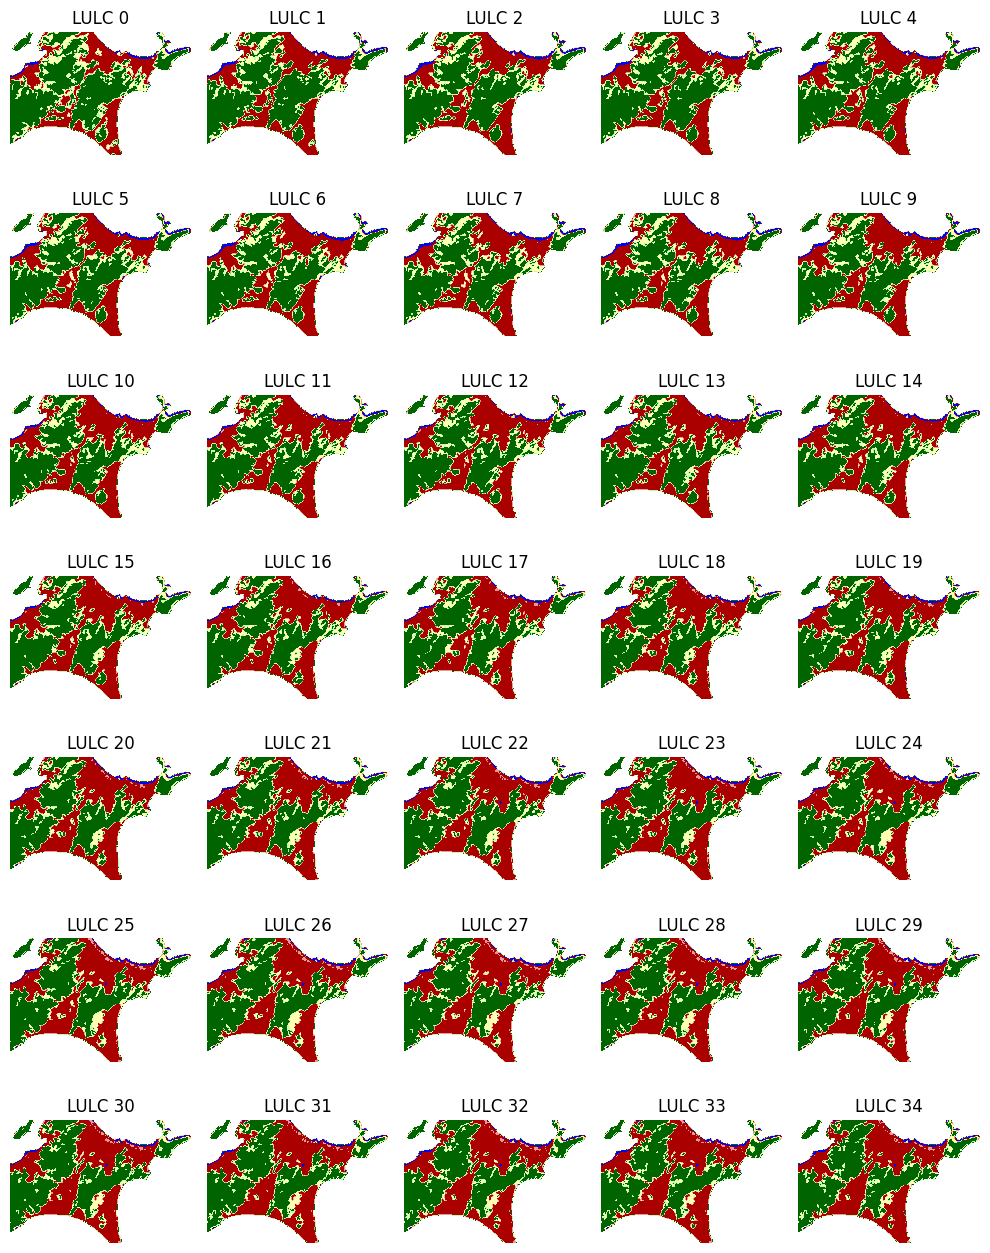

In [10]:

plotSideBySide(7,5, imagens)

Criando o Dataset



In [11]:
dataset = imagens

#até agora temos dimensões (num_imagens, largura, altura, canais)
#precisamos adicionar uma dimensão extra para dar input na rede
#incrementamos uma dimensão na posicao 0
#(num_ensaios, num_imagens, largura, altura)
dataset = np.expand_dims(dataset, axis=0)
dataset = np.transpose(dataset, (0, 1, 3, 4, 2))
print(dataset.shape)

(1, 36, 216, 319, 1)


In [12]:
#dataset de teino e validacao serão os mesmos, mas shiftados em 1 posicao

train_dataset = dataset
val_dataset = dataset

def create_shifted_frames(data):
    x = data[ :, 0 : data.shape[1] - 1, :, :]
    y = data[ :, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

In [13]:
#analisando as dimensões das variáveis de treinamento e validacao
print(f"Dim train_dataset: {x_train.shape} {y_train.shape}")
print(f"Dim val_dataset: {x_val.shape} {y_val.shape}")

Dim train_dataset: (1, 35, 216, 319, 1) (1, 35, 216, 319, 1)
Dim val_dataset: (1, 35, 216, 319, 1) (1, 35, 216, 319, 1)


Construindo o modelo:

$(None, 1, k\_imagens, largura, altura, canais) ↦$ \\
$LSTMConv2D + BatchNorm ↦ $ \\
$LSTMConv2D + BatchNorm ↦ $ \\
$LSTMConv2D ↦ $ \\
$LSTMConv3D ↦ (width, heigth, chanels)$

In [14]:
#A arquitetura do modelo se mantém em relação ao tutorial

#Nossos dados consistem de uma matriz de dados: imagem = [[1, 2, 3], [4,5,6], [0, 1, 2]]
#Nossas imagens são uma matriz de inteiros de 0 até 6, representando classes de interesse (flores,ta, area urbana, corpos d'água)
#O problema consiste no produto da rede. Aparentemente, por causa da função de perda ser 'CrossBinary',
#ela retorna uma matriz de mesma dimensão mas com valores floats, por exemplo
#imagem_predita = [[0.001, 0.11, 0.001], [0.023, 0.001, 0.999], [0.871, 0.500, 0.500]]

#Tentei trocar paara 'sparse categorical' e 'categorical', mas ainda mantemos o mesmo problema
#os valores retornados se tornam, por exemplo, uma matriz com valores floats, mas maiores do que o intervalo [0,1]
#imagem_nova = [[-1.111, -2.011, 4.001],[...],[...]]


In [15]:
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Input
from tensorflow.keras.models import Sequential

In [16]:
model = Sequential()

model.add(Input(shape=(None, *x_train.shape[2:])))
model.add(ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu"))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu"))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=16, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu"))
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), padding="same"))

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())

In [17]:
#estatisticas
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 216, 319,    105728    
                             32)                                 
                                                                 
 batch_normalization (Batch  (None, None, 216, 319,    128       
 Normalization)              32)                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 216, 319,    204928    
                             32)                                 
                                                                 
 batch_normalization_1 (Bat  (None, None, 216, 319,    128       
 chNormalization)            32)                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 216, 319,    3

Treinamento

In [18]:
#Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

#Hiperparâmetros
epochs = 40
batch_size = 2

#Treinamento do modelo
model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/40
1/1 [==============================] - 25s 25s/step - loss: 14.2430 - val_loss: -0.6837 - lr: 0.0010
Epoch 2/40
1/1 [==============================] - 3s 3s/step - loss: 6.1476 - val_loss: -5.2170 - lr: 0.0010
Epoch 3/40
1/1 [==============================] - 4s 4s/step - loss: 7.5916 - val_loss: -5.7351 - lr: 0.0010
Epoch 4/40
1/1 [==============================] - 3s 3s/step - loss: 5.9048 - val_loss: 2.1102 - lr: 0.0010
Epoch 5/40
1/1 [==============================] - 3s 3s/step - loss: 5.2332 - val_loss: 4.4010 - lr: 0.0010
Epoch 6/40
1/1 [==============================] - 3s 3s/step - loss: 3.9762 - val_loss: nan - lr: 0.0010
Epoch 7/40
1/1 [==============================] - 4s 4s/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 8/40
1/1 [==============================] - 4s 4s/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 9/40
1/1 [==============================] - 3s 3s/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 10/40
1/1 [======================

É possível salvar o modelo para usá-lo já treinado depois


In [19]:
#model.save('/content/gdrive/MyDrive/ILHA_SANTA_CATARINA_ANN_py/model/rede_treinada.h5')

Predição

In [23]:
# Select a random example from the validation dataset.
example = val_dataset[0]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]



In [24]:
print(frames.shape)

frames = np.expand_dims(frames, axis = 0)
original_frames = np.expand_dims(original_frames, axis = 0)
print(frames.shape)
print(original_frames.shape)

(10, 216, 319, 1)
(1, 10, 216, 319, 1)
(1, 26, 216, 319, 1)


1/1 [==============================] - 0s 159ms/step


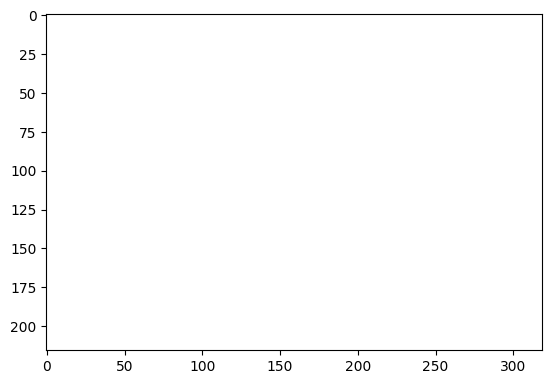

In [25]:
for i in range(1):
  nova_predicao = model.predict(frames)
  predicted_frame  = nova_predicao[0][9]
  plt.imshow(predicted_frame)
  plt.show()
  predicted_frame  = np.expand_dims(predicted_frame, axis= 0)   #para concatenar é necessário ter dimensões iguais
  predicted_frame  = np.expand_dims(predicted_frame, axis= 0)   #aplicando a transformação (x,y,c) --> (1, 1, x, y, c)
  frames = np.concatenate((frames, predicted_frame), axis = 1)